In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
from kafka import KafkaConsumer
from kafka import KafkaProducer
from kafka.admin import KafkaAdminClient, NewTopic

import torch
import torch.nn as nn
import torch.optim as optim

import _thread as thread
import src_loader
from kafka_client.kafka_util import sim_traffic, get_msg
from models.simple_models import CNN1D_1l_RNN as RNN
from train_loops import forward_walk_train as train
from util.plotting import LiveGraph, plot_signal
import numpy as np
from tqdm.notebook import tqdm
from scipy import interpolate
from csaps import csaps
import datetime

import deploy_lmu

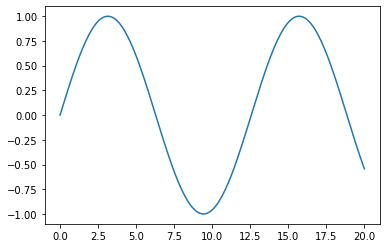

In [3]:
IP = "35.246.236.92:31090"
SIGNAL = lambda t: np.sin(t/2)
SEQ_LEN = 64
FUTURE = 32
CELL = "LSTM"
HIDDEN_DIM = 16
STACK = 3
LR =  0.001
TS_LEN = 50
INTERVAL = 300 #in ms
TOPIC_IN = "metric"
TOPIC_OUT = "long-term-predictions"
SHORT = "short-term-predictions"
dev = torch.device("cuda" if torch.cuda.is_available else "cpu")

plot_signal(SIGNAL)

In [4]:

"""admin_client = KafkaAdminClient(
    bootstrap_servers=IP,
    client_id="Admin",
    api_version=(2,5,1)
)

topic_list = []
topic_list.append(NewTopic(name=TOPIC_IN,
                           num_partitions=1,
                           replication_factor=2
                          ))
topic_list.append(NewTopic(name=TOPIC_OUT,
                          num_partitions=1,
                          replication_factor=2
                          ))

topic_list.append(NewTopic(name=SHORT,
                          num_partitions=1,
                          replication_factor=2
                          ))

admin_client.create_topics(new_topics=topic_list, validate_only=False)
"""

'admin_client = KafkaAdminClient(\n    bootstrap_servers=IP,\n    client_id="Admin",\n    api_version=(2,5,1)\n)\n\ntopic_list = []\ntopic_list.append(NewTopic(name=TOPIC_IN,\n                           num_partitions=1,\n                           replication_factor=2\n                          ))\ntopic_list.append(NewTopic(name=TOPIC_OUT,\n                          num_partitions=1,\n                          replication_factor=2\n                          ))\n\ntopic_list.append(NewTopic(name=SHORT,\n                          num_partitions=1,\n                          replication_factor=2\n                          ))\n\nadmin_client.create_topics(new_topics=topic_list, validate_only=False)\n'

In [5]:
"""thread.start_new_thread(sim_traffic, (SIGNAL, IP, TOPIC_IN, ))

history = torch.empty((1,1,10000),dtype=torch.float32)

model = RNN(HIDDEN_DIM,
            SEQ_LEN,
            stacked=STACK,
            future = FUTURE,
            k_size=4,
            stride=2, 
            cell_type=CELL)

optim = optimizer = optim.AdamW(model.parameters(), lr=LR)
criterion = nn.MSELoss()
model = model.to(dev)"""

'thread.start_new_thread(sim_traffic, (SIGNAL, IP, TOPIC_IN, ))\n\nhistory = torch.empty((1,1,10000),dtype=torch.float32)\n\nmodel = RNN(HIDDEN_DIM,\n            SEQ_LEN,\n            stacked=STACK,\n            future = FUTURE,\n            k_size=4,\n            stride=2, \n            cell_type=CELL)\n\noptim = optimizer = optim.AdamW(model.parameters(), lr=LR)\ncriterion = nn.MSELoss()\nmodel = model.to(dev)'

In [6]:
#graph = LiveGraph()
#graph.show()

In [7]:
"""train_dur = loss = None
with LiveGraph(backend='nbAgg') as h:
    
    line_pred = h.add_line()
    line_smooth = h.add_line()
    line_sig = h.add_line()
    
    with tqdm(enumerate(get_msg(TOPIC_IN, IP))) as pbar:
        for i, msg in pbar:

            time = msg.value["occurredOn"]
            #print(time)
            load = msg.value["kafkaMessagesPerSecond"]
            history[:,:,i] = load
            #print(f"\n{i+1} values received so far")
            if i >= SEQ_LEN + FUTURE - 1:

                bound = TS_LEN + SEQ_LEN + FUTURE -1

                if i < bound - 1:
                    ts = history[:,:,0:(i+1)].to(dev)
                else:
                    ts = history[:,:,(i+1-bound):(i+1)].to(dev)
                
                #print(ts)
                train_dur, loss = train(model,
                                        ts,
                                        optim,
                                        criterion,
                                        seq_len=SEQ_LEN,
                                        future=FUTURE
                                        )

                with torch.no_grad():
                    pred = model(history[:,:,(i+1-SEQ_LEN):(i+1)].to(dev))[0].cpu()
                    print(history[0,0,(i+1-SEQ_LEN):(i+1)])
                    line_sig.update(range(SEQ_LEN), history[0,0,(i+1-SEQ_LEN):(i+1)])
                    line_pred.update(range(SEQ_LEN, SEQ_LEN+ FUTURE), pred)
                    spline_smooth = csaps(range(SEQ_LEN, SEQ_LEN+ FUTURE),
                                          pred,
                                          range(SEQ_LEN, SEQ_LEN+ FUTURE),
                                          smooth=0.8)
                    line_smooth.update(range(SEQ_LEN, SEQ_LEN+ FUTURE), spline_smooth)
                    
            #msg_out = {i:datetime.}
                    
            pbar.set_postfix(timestamp=time, train_duration=train_dur, loss=loss)"""
            
    
    

'train_dur = loss = None\nwith LiveGraph(backend=\'nbAgg\') as h:\n    \n    line_pred = h.add_line()\n    line_smooth = h.add_line()\n    line_sig = h.add_line()\n    \n    with tqdm(enumerate(get_msg(TOPIC_IN, IP))) as pbar:\n        for i, msg in pbar:\n\n            time = msg.value["occurredOn"]\n            #print(time)\n            load = msg.value["kafkaMessagesPerSecond"]\n            history[:,:,i] = load\n            #print(f"\n{i+1} values received so far")\n            if i >= SEQ_LEN + FUTURE - 1:\n\n                bound = TS_LEN + SEQ_LEN + FUTURE -1\n\n                if i < bound - 1:\n                    ts = history[:,:,0:(i+1)].to(dev)\n                else:\n                    ts = history[:,:,(i+1-bound):(i+1)].to(dev)\n                \n                #print(ts)\n                train_dur, loss = train(model,\n                                        ts,\n                                        optim,\n                                        criterion,\n       

{'kafka': {'ip': '35.246.236.92:31090', 'in_topic': 'metric', 'out_topic': 'long-term-predictions', 'input_interval': 10, 'avg_agg_len': 1, 'expected_period': 12, 'self_simulate': False, 'save_data': True}, 'model': {'seq_len': 64, 'pred_len': 16, 'hidden_dim': 16, 'memory_dim': 64, 'order': 1}, 'train': {'time': 7, 'buffer': 5, 'LR': 0.001, 'pretrain_iters': 300}}
running subscriber thread
pre train
wait for data to build up
find max training iterations
forward walking training steps per round: 63
original backend: module://ipykernel.pylab.backend_inline
switch to backend: nbAgg


<IPython.core.display.Javascript object>


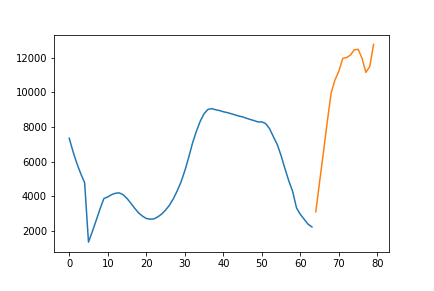

restore to backend: module://ipykernel.pylab.backend_inline


KeyboardInterrupt: 

In [8]:
deploy_lmu.main(live_plotting=True)